In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!ls data

X_test.csv
X_train.csv
sample_submission.csv
y_train.csv


# Load Data

In [ ]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')
X_test = pd.read_csv('data/X_test.csv')

# EDA

In [49]:
print(X_train.shape, X_test.shape)
X_train.head()

(487680, 13) (488448, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [8]:
print(y_train.shape)
y_train.head()

(3810, 3)


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [26]:
np.all(X_train['series_id'].unique() == y_train['series_id'].unique())

True

In [23]:
np.all(X_train['series_id'].value_counts().values == 128)

True

In [53]:
X_test['series_id'].nunique(), np.all(X_test['series_id'].value_counts().values == 128)

(3816, True)

The training data contains 3810 series, each comprised of 128 measurements. The test data contains 3816 series, each comprised of 128 measurements.

73


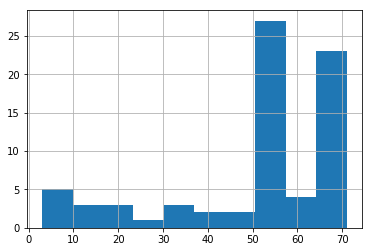

In [62]:
print(y_train['group_id'].nunique())
y_train['group_id'].value_counts().hist();

In [48]:
y_train['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [45]:
num_surfaces_in_group = []

for group in y_train['group_id'].unique():
    num_surfaces_in_group.append(len(y_train.loc[y_train['group_id'] == group, 'surface'].unique()))
    
np.all(np.array(num_surfaces_in_group) == 1)

True

Each of the 73 groups corresponds to a single surface type. The groups and classes (surfaces) are both heavily imbalanced.